# Introduction to NumPyro

[NumPyro](https://num.pyro.ai/en/latest/index.html#) is a probabilistic programming library that combines the flexibility of `numpy` with the probabilistic modeling capabilities of `pyro`, making it an excellent choice for researchers and data scientists. In this introductory tutorial, we'll explore the basics of `numpyro` and how to get started with probabilistic programming in a hands-on manner.

## Components of a Numpyro program

In a NumPyro program, you define a probabilistic model that consists of various elements. Let's break down the key elements of a typical program using NumPyro:

1. <font color='orange'>Importing Libraries:</font>

At the beginning of your NumPyro program, you import the necessary libraries, including NumPyro and other required dependencies like JAX. For example:

In [11]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

import jax
import jax.numpy as jnp

import arviz as az

import matplotlib.pyplot as plt


2. <font color='orange'>Defining the Model Function:</font>

In NumPyro, you define your probabilistic model as a Python function. This function encapsulates the entire model, including both the prior distributions and the likelihood. Typically, the model function takes one or more arguments, such as data or model parameters, and returns a set of latent variables and observations.

In [4]:
def model():
    pass

3. <font color='orange'>Prior Distributions:</font>

Inside the model function, you define prior distributions for the model parameters. These prior distributions represent your beliefs about the parameters before observing any data. You use the `numpyro.sample` function to specify these priors. For example, in `mean = numpyro.sample("mean", dist.Normal(0, 1))` and `scale = numpyro.sample("scale", dist.Exponential(1))` within a function define `mean` and `scale` as random variables sampled from specific prior distributions.


4. <font color='orange'>Likelihood:</font>

After specifying the prior distributions, you define the likelihood of your observed data by adding `obs=data` to the sampling statement of a variable. The likelihood represents the probability distribution of your observed data given the model parameters. It describes how likely it is to observe the data under different parameter values. In the example below, the `numpyro.sample` function is used to define the likelihood of the data points given the mean and scale parameters.

In [5]:
def model(data):
    
    # Define prior distributions for model parameters
    mean = numpyro.sample("mean", dist.Normal(0, 1))
    scale = numpyro.sample("scale", dist.Exponential(1))

    # Define likelihood
    numpyro.sample("obs", dist.Normal(mean, scale), obs=data)


5. <font color='orange'>Inference Algorithm:</font>

After defining your model, you need to choose an inference algorithm to estimate the posterior distribution of model parameters. NumPyro supports various inference algorithms, including NUTS (No-U-Turn Sampler) and SVI (Stochastic Variational Inference). You initialize and configure the chosen inference algorithm according to your requirements.

In [6]:
nuts_kernel = NUTS(model)

6. <font color='orange'>Performing Inference:</font>

You use the configured inference algorithm to perform Bayesian inference. In the example, Markov Chain Monte Carlo inference is performed using the `MCMC` class. The `run` method of the `MCMC` object is called to run the inference process.

```{margin}
I have set here `progress_bar=False` to reduce amount of output in the resulting html of the lecture file. In practice, you often want to set the value to `True` to know how long the model will still take to complete.
```

In [7]:
# data
data = jnp.array([2.3, 3.9, 1.7, -0.8, 2.5])

mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2, chain_method='parallel', progress_bar=False)
mcmc.run(jax.random.PRNGKey(0), data)

<ipython-input-7-e0c8203ce43f>:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2, chain_method='parallel')
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3513.48it/s, 3 steps of size 7.44e-01. acc. prob=0.89]


Note that the in the call above, we provided the number of chains `num_chains=2`, number of samples `num_samples=1000` and number of warm-up samples `num_warmup=1000`.

9. <font color='orange'>Posterior Analysis:</font>

After running the inference, you can retrieve posterior samples of the model parameters. These samples represent the estimated posterior distribution of the parameters given the observed data. You can then analyze these samples to make inferences about your model.

In [8]:
# Get the posterior samples
posterior_samples = mcmc.get_samples()

# Print summary statistics of posterior
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mean      1.17      0.69      1.19      0.04      2.27    885.10      1.01
     scale      1.87      0.62      1.74      0.97      2.72    783.04      1.00

Number of divergences: 0


10. <font color='orange'>Visualizing inference results</font>

- Finally, you can perform various tasks such as visualizing the posterior distributions, computing summary statistics, and making predictions or inferences based on the posterior samples.

array([[<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'mean'}>],
       [<AxesSubplot:title={'center':'scale'}>,
        <AxesSubplot:title={'center':'scale'}>]], dtype=object)

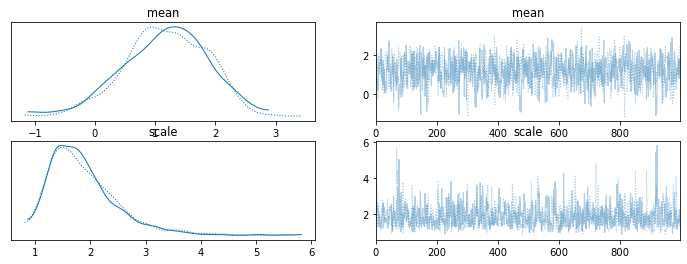

In [9]:
# Viosualise posterior distributions and trace plots
az.plot_trace(mcmc)

5. `plate` <font color='orange'>for repetition</font>

We often work with multiple data points that share the same statistical structure. In such cases you might want to, or need to, use plates. The `numpyro.plate` context manager allows you to create a plate, which represents a repeated structure for data. It's used to efficiently handle repeated observations. In the example, `numpyro.plate` is used to specify that the likelihood applies to multiple data points.


In [10]:
def model(data):
    
    # Define prior distributions for model parameters
    mean = numpyro.sample("mean", dist.Normal(0, 1))
    scale = numpyro.sample("scale", dist.Exponential(1))

    # Define likelihood with a data plate
    with numpyro.plate("data_plate", len(data)):
        obs = numpyro.sample("obs", dist.Normal(mean, scale), obs=data)


nuts_kernel = NUTS(model)

# data
data = jnp.array([2.3, 3.9, 1.7, -0.8, 2.5])

mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2, chain_method='parallel', progress_bar=False)
mcmc.run(jax.random.PRNGKey(0), data)

# Get the posterior samples
posterior_samples = mcmc.get_samples()

# Print summary statistics of posterior
mcmc.print_summary()

<ipython-input-10-ad9d2919cc83>:17: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2, chain_method='parallel')
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2197.01it/s, 3 steps of size 7.44e-01. acc. prob=0.89]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mean      1.17      0.69      1.19      0.04      2.27    885.10      1.01
     scale      1.87      0.62      1.74      0.97      2.72    783.04      1.00

Number of divergences: 0


## Summary

The typical elements that we will need to write are model in Numpyro are as follows:

- parameters sampled with  <font color='green'>`numpyro.sample`</font>
- parameters sampled from any of the available distributsions using, e.g.  <font color='green'>`dist.Beta(alpha, beta)`</font> 
- likelihood constructed by adding `obs=...` to the sampling statement: <font color='green'>`numpyro.sample('obs', dist.Binomial(n, p), obs=h)`</font>
- the sampling algorithm which we would like to use. NUTS is a good default oprtion: <font color='green'>`kernel = NUTS(model)` </font>,
- number of warm-up steps, number of iterations, number of chains, e.g. <font color='green'>`MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)`</font>,
- using <font color='green'>`Predictive` </font> class we can generate predictions.




`````{admonition} Task 16
:class: tip
- You might have correctly noticed that we have not looked at the `Predictive` capability. Study the documentation of Numpyro (in particular, `numpyro.infer`) and demonstrate the `Predictive` command on the example shown above.
- Study the documentation of Numpyro (in particular, `numpyro.diagnostics`) to understand what the `hpdi` command does. Apply it to the example shown above.
`````

## Outro

NumPyro is a versatile library for probabilistic programming that combines the power of NumPy and Pyro. In this introductory tutorial, we've covered the basics of defining a probabilistic model, performing MCMC inference, and visualizing the results. As you delve deeper into probabilistic programming with NumPyro, you'll be able to build more complex and customized models for your specific applications. Happy modeling!